# Séries temporelles

Ici on fait tout le code pour étudier les séries temporelles.

Comment étudier une série temporelle ?  
1/	Visualiser la série : saisonnalité ? comportement récurrent ?  
2/	1ère transformation (par exemple transformation en log)  
3/	Est-ce que la série est stationnaire ? (test ADF, test KPSS)  
        - OUI : modèle ARMA  
        - NON : modèle ARIMA -> si on a un problème de racine unitaire, on va faire une transformation sur la série afin d’enlever ce problème de racine unitaire. On aura la série transformée, et si elle est stationnaire on pourra regarder p et q (critère bayésien).  
4/	Processus classique de série temporelle : prévision à t+1, t+2, etc.  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. Données trafic aérien - France

In [9]:
df_air_trafic = pd.read_csv("df_air_trafic_corrigee.csv", index_col=0)
df_air_trafic

,country_origin,citydest,sheduled_time_start,seats,number_planes,Year,Month,Day,Year-Month
64488,Hungary,Paris,2017-05-16,462.0,3,2017,5,16,2017-05
64345,Germany,Basel,2017-05-16,592.0,5,2017,5,16,2017-05
64346,France,Toulon,2017-05-16,334.0,3,2017,5,16,2017-05
64347,France,Bordeaux,2017-05-16,1736.0,15,2017,5,16,2017-05
64348,Portugal,Toulouse,2017-05-16,437.0,3,2017,5,16,2017-05
...,...,...,...,...,...,...,...,...,...
265668,Germany,Paris,2021-12-07,1314.0,9,2021,12,7,2021-12
265666,Portugal,Paris,2021-12-07,183.0,2,2021,12,7,2021-12
265684,France,Nice,2021-12-07,1387.0,9,2021,12,7,2021-12
265672,Tunisia,Paris,2021-12-07,298.0,2,2021,12,7,2021-12


### 1.1. Moyenne mobile

#### Sur la base sans le traitement des valeurs manquantes

In [12]:
# On commence par visualiser la table
df_air_traffic_france = pd.read_csv('france_air_traffic_210712.csv')
df_air_traffic_france['sheduled_time_start']=pd.to_datetime(df_air_traffic_france['sheduled_time_start'])
df_air_traffic_france.head(5)

,country_origin,citydest,sheduled_time_start,seats,number_planes
0,Albania,Nantes,2021-10-12,189.0,1
1,Albania,Paris,2017-08-17,189.0,1
2,Albania,Paris,2017-08-19,189.0,1
3,Albania,Paris,2017-08-22,189.0,1
4,Albania,Paris,2020-08-12,148.0,1


Text(0, 0.5, 'Number of planes')

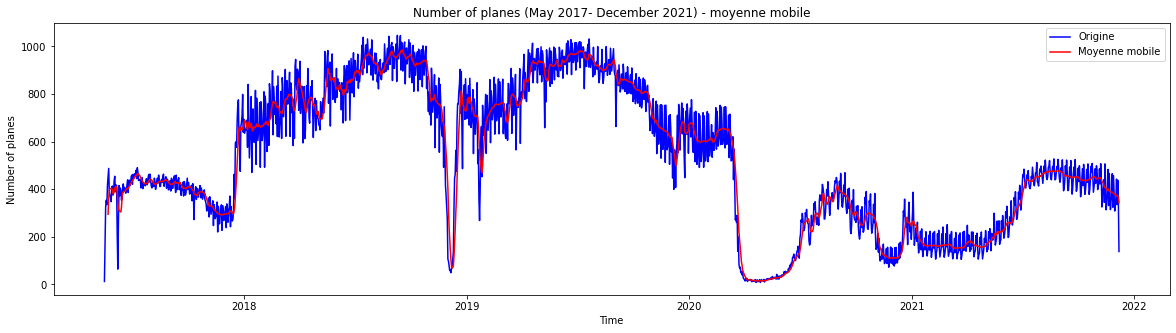

In [14]:
df_air_traffic_france4=df_air_traffic_france.groupby('sheduled_time_start').sum()
df_air_traffic_france4=df_air_traffic_france4.reset_index()
df_air_traffic_france5 = df_air_traffic_france4['number_planes']

x=df_air_traffic_france4["sheduled_time_start"]
y=df_air_traffic_france4["number_planes"]
z=rolling_mean = df_air_traffic_france5.rolling(window = 7).mean()

fig = plt.figure(1, figsize=(20, 5))
plt.plot(x,y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title('Number of planes (May 2017- December 2021) - moyenne mobile')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Number of planes')

#### Sur la base avec traitement des valeurs manquantes

In [10]:
#df_air_traffic_imput2_date c'est la base df_air_trafic dans laquelle on a sommé les avions et sièges par jour de départ

df_air_traffic_imput2_date = df_air_trafic.groupby('sheduled_time_start').agg({'seats':'sum','number_planes':'sum'})
df_air_traffic_imput2_date

,seats,number_planes
sheduled_time_start,,
2017-05-16,137671.0,830
2017-05-17,158894.0,959
2017-05-18,163676.0,982
2017-05-19,129127.0,761
2017-05-20,151465.0,869
...,...,...
2021-12-03,77261.0,442
2021-12-04,62891.0,335
2021-12-05,78047.0,437


Text(0, 0.5, "Nombre d'avions")

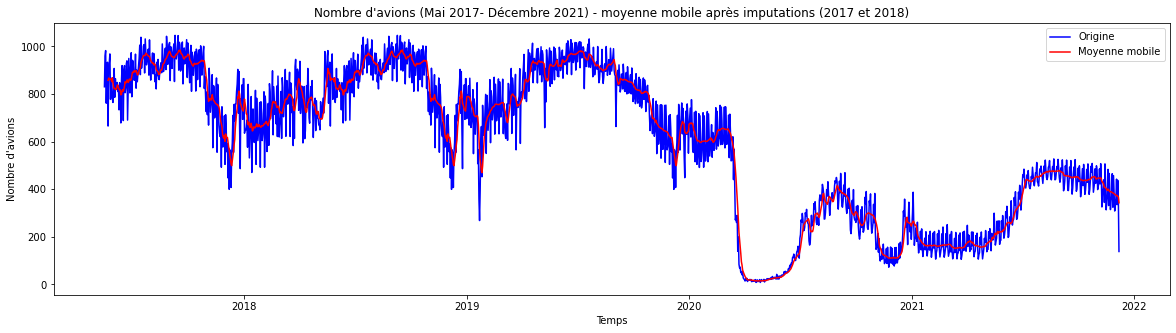

In [20]:
#on regarde la série temporelle et la moyenne mobile du nombre d'avions après cette nouvelle imputation

df_air_traffic_imput2_avions = df_air_traffic_imput2_date['number_planes']
df_air_traffic_imput2_date.reset_index(inplace=True)

x = df_air_traffic_imput2_date["sheduled_time_start"]
y = df_air_traffic_imput2_date["number_planes"]
z = rolling_mean = df_air_traffic_imput2_avions.rolling(window = 7).mean()

fig = plt.figure(1, figsize=(20, 5))
plt.plot(x,y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title("Nombre d'avions (Mai 2017- Décembre 2021) - moyenne mobile après imputations (2017 et 2018)")
plt.legend(loc = 'best')
plt.xlabel('Temps')
plt.ylabel("Nombre d'avions")

### 1.2. Test - Etude de la tendance et de la saisonnalité 

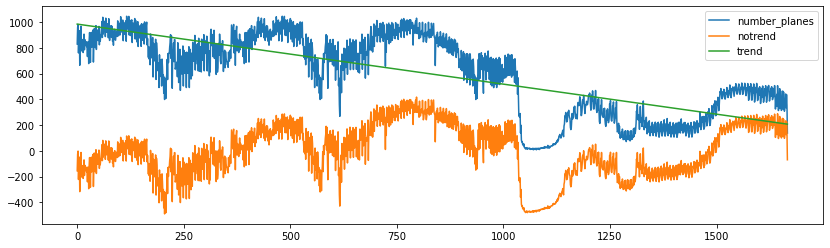

In [21]:
# but: on enlève une tendance linéaire

from statsmodels.tsa.tsatools import detrend

notrend = detrend(df_air_traffic_imput2_date['number_planes'])
df_air_traffic_imput2_date["notrend"] = notrend
df_air_traffic_imput2_date["trend"] = df_air_traffic_imput2_date['number_planes'] - notrend
df_air_traffic_imput2_date.plot(y=["number_planes", "notrend", "trend"], figsize=(14,4));

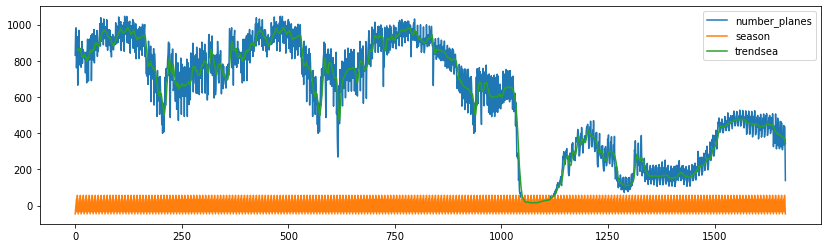

In [22]:
# retirer la saisonnalité 

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df_air_traffic_imput2_date["number_planes"].values.ravel(), period=7, two_sided=False)
df_air_traffic_imput2_date["season"] = res.seasonal
df_air_traffic_imput2_date["trendsea"] = res.trend
df_air_traffic_imput2_date.plot(y=["number_planes", "season", "trendsea"], figsize=(14,4));

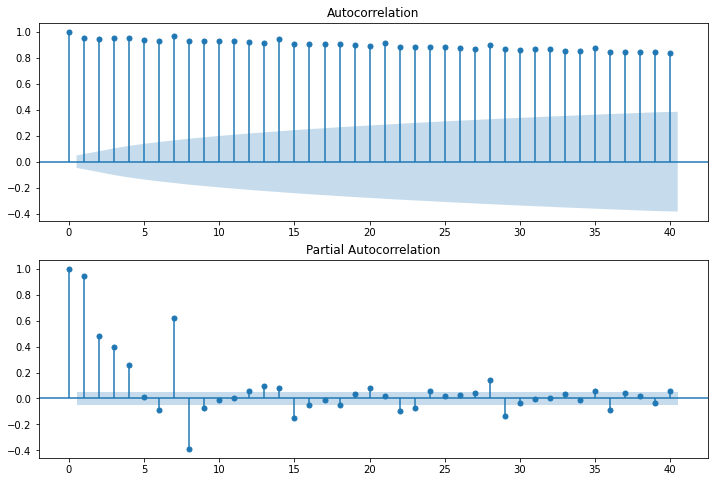

In [23]:
# autocorrélation

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_air_traffic_imput2_date["number_planes"], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_air_traffic_imput2_date["number_planes"], lags=40, ax=ax2);

## 2. Données officielles - France

In [25]:
#importation des données
df_France_Official_Data = pd.read_csv('France_Official_Data.csv')
df_France_Official_Data['date']=pd.to_datetime(df_France_Official_Data['date'])
df_France_Official_Data

,date,variable,department,individus,value_in_thousands
0,2011-01-01,Arrivées dans l'hôtellerie,Ain,Non-résidents,7.41
1,2011-02-01,Arrivées dans l'hôtellerie,Ain,Non-résidents,9.54
2,2011-03-01,Arrivées dans l'hôtellerie,Ain,Non-résidents,12.55
3,2011-04-01,Arrivées dans l'hôtellerie,Ain,Non-résidents,13.03
4,2011-05-01,Arrivées dans l'hôtellerie,Ain,Non-résidents,12.97
...,...,...,...,...,...
24955,2021-06-01,Arrivées dans l'hôtellerie,Yvelines,Résidents,65.91
24956,2021-07-01,Arrivées dans l'hôtellerie,Yvelines,Résidents,71.18
24957,2021-08-01,Arrivées dans l'hôtellerie,Yvelines,Résidents,56.66
24958,2021-09-01,Arrivées dans l'hôtellerie,Yvelines,Résidents,73.9


In [26]:
df_France_Official_Data["value_in_thousands"] = df_France_Official_Data["value_in_thousands"].replace("(O)", np.nan) #remplacer les (O) par des NA
df_France_Official_Data["value_in_thousands"] = df_France_Official_Data["value_in_thousands"].apply(pd.to_numeric) #convertir la variable

### 2.1. Moyenne mobile

#### 2.1.1. Sur l'ensemble des individus

Text(0, 0.5, "Nombre d'arrivées dans l'hôtellerie")

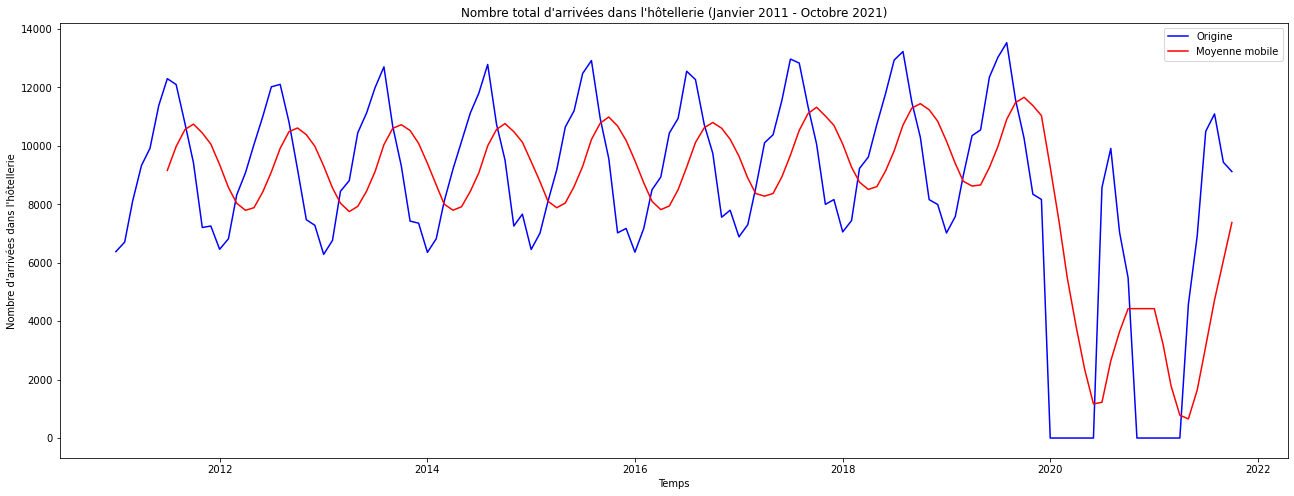

In [27]:
df_arrivees_hotel_temps = df_France_Official_Data.groupby('date').sum()
df_arrivees_hotel_temps.reset_index(inplace=True)
df_arrivees_hotel_value = df_arrivees_hotel_temps['value_in_thousands']

x = df_arrivees_hotel_temps["date"]
y = df_arrivees_hotel_temps["value_in_thousands"]
z = rolling_mean = df_arrivees_hotel_value.rolling(window = 7).mean()

fig = plt.figure(1, figsize=(22, 8))

plt.plot(x, y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title("Nombre total d'arrivées dans l'hôtellerie (Janvier 2011 - Octobre 2021)")
plt.legend(loc = 'best')
plt.xlabel('Temps')
plt.ylabel("Nombre d'arrivées dans l'hôtellerie")

#### 2.1.2. Arrivées dans l'hôtellerie des résidents

In [28]:
df_arrivees_hotel_residents = df_France_Official_Data[df_France_Official_Data['individus']=="Résidents"]
df_arrivees_hotel_residents.sort_values(by=['date'], inplace=True)
df_arrivees_hotel_residents

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,date,variable,department,individus,value_in_thousands
130,2011-01-01,Arrivées dans l'hôtellerie,Ain,Résidents,39.91
19630,2011-01-01,Arrivées dans l'hôtellerie,Pyrénées-Orientales,Résidents,32.65
19370,2011-01-01,Arrivées dans l'hôtellerie,Pyrénées-Atlantiques,Résidents,60.39
2210,2011-01-01,Arrivées dans l'hôtellerie,Aube,Résidents,30.37
19110,2011-01-01,Arrivées dans l'hôtellerie,Puy-de-Dôme,Résidents,57.28
...,...,...,...,...,...
17419,2021-10-01,Arrivées dans l'hôtellerie,Moselle,Résidents,73.15
17679,2021-10-01,Arrivées dans l'hôtellerie,Nièvre,Résidents,19.82
17939,2021-10-01,Arrivées dans l'hôtellerie,Nord,Résidents,153.80
15599,2021-10-01,Arrivées dans l'hôtellerie,Maine-et-Loire,Résidents,76.35


Text(0, 0.5, "Nombre d'arrivées des résidents français dans l'hôtellerie")

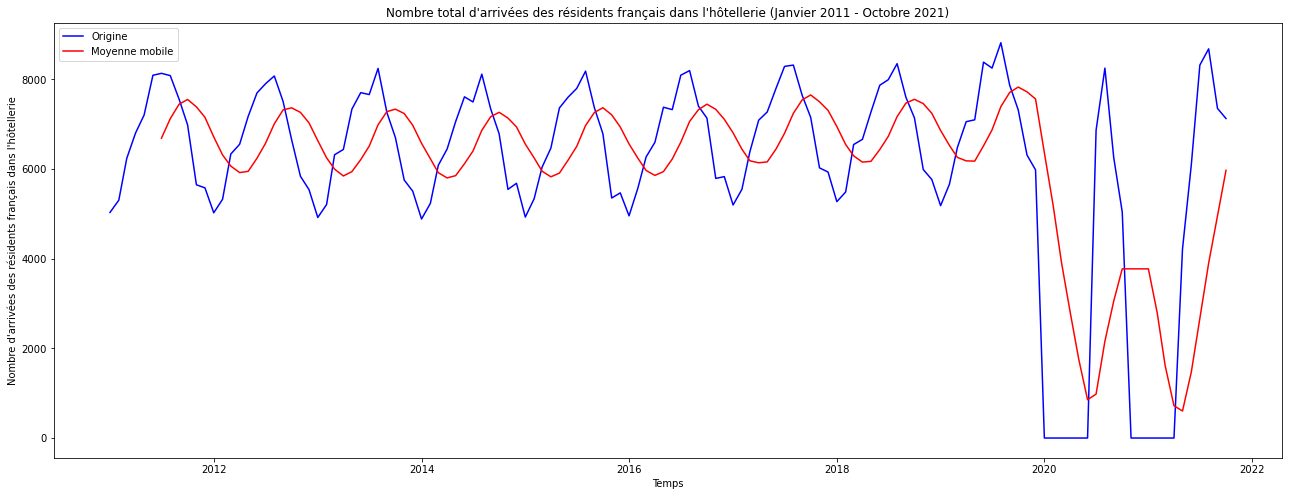

In [29]:
df_arrivees_hotel_residents_temps = df_arrivees_hotel_residents.groupby('date').sum()
df_arrivees_hotel_residents_temps.reset_index(inplace=True)
df_arrivees_hotel_residents_value = df_arrivees_hotel_residents_temps['value_in_thousands']

x = df_arrivees_hotel_residents_temps["date"]
y = df_arrivees_hotel_residents_temps["value_in_thousands"]
z = rolling_mean = df_arrivees_hotel_residents_value.rolling(window = 7).mean()

fig = plt.figure(1, figsize=(22, 8))

plt.plot(x, y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title("Nombre total d'arrivées des résidents français dans l'hôtellerie (Janvier 2011 - Octobre 2021)")
plt.legend(loc = 'best')
plt.xlabel('Temps')
plt.ylabel("Nombre d'arrivées des résidents français dans l'hôtellerie")

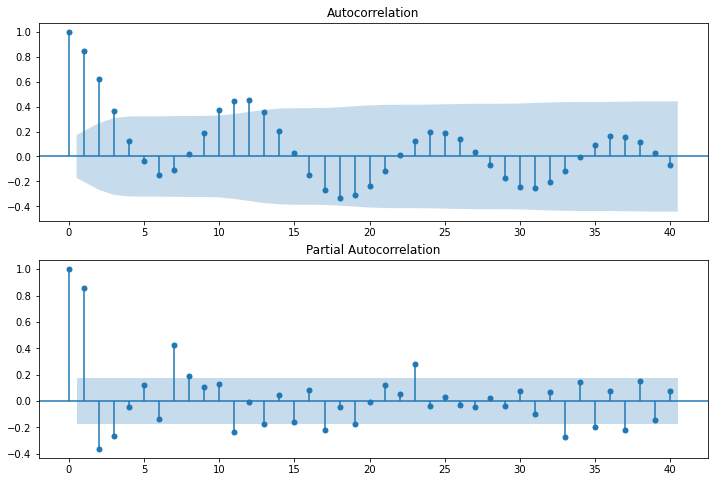

In [39]:
# autocorrélation

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_arrivees_hotel_residents_value, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_arrivees_hotel_residents_value, lags=40, ax=ax2);

#### 2.1.3. Arrivées dans l'hôtellerie des non-résidents

In [30]:
df_arrivees_hotel_non_residents = df_France_Official_Data[df_France_Official_Data['individus']=="Non-résidents"]
df_arrivees_hotel_non_residents.sort_values(by=['date'], inplace=True)
df_arrivees_hotel_non_residents

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,date,variable,department,individus,value_in_thousands
0,2011-01-01,Arrivées dans l'hôtellerie,Ain,Non-résidents,7.41
19500,2011-01-01,Arrivées dans l'hôtellerie,Pyrénées-Orientales,Non-résidents,3.77
19240,2011-01-01,Arrivées dans l'hôtellerie,Pyrénées-Atlantiques,Non-résidents,5.15
2080,2011-01-01,Arrivées dans l'hôtellerie,Aube,Non-résidents,4.40
18980,2011-01-01,Arrivées dans l'hôtellerie,Puy-de-Dôme,Non-résidents,3.50
...,...,...,...,...,...
17289,2021-10-01,Arrivées dans l'hôtellerie,Moselle,Non-résidents,13.65
17549,2021-10-01,Arrivées dans l'hôtellerie,Nièvre,Non-résidents,1.90
17809,2021-10-01,Arrivées dans l'hôtellerie,Nord,Non-résidents,27.08
15469,2021-10-01,Arrivées dans l'hôtellerie,Maine-et-Loire,Non-résidents,5.35


Text(0, 0.5, "Nombre d'arrivées des non-résidents français dans l'hôtellerie")

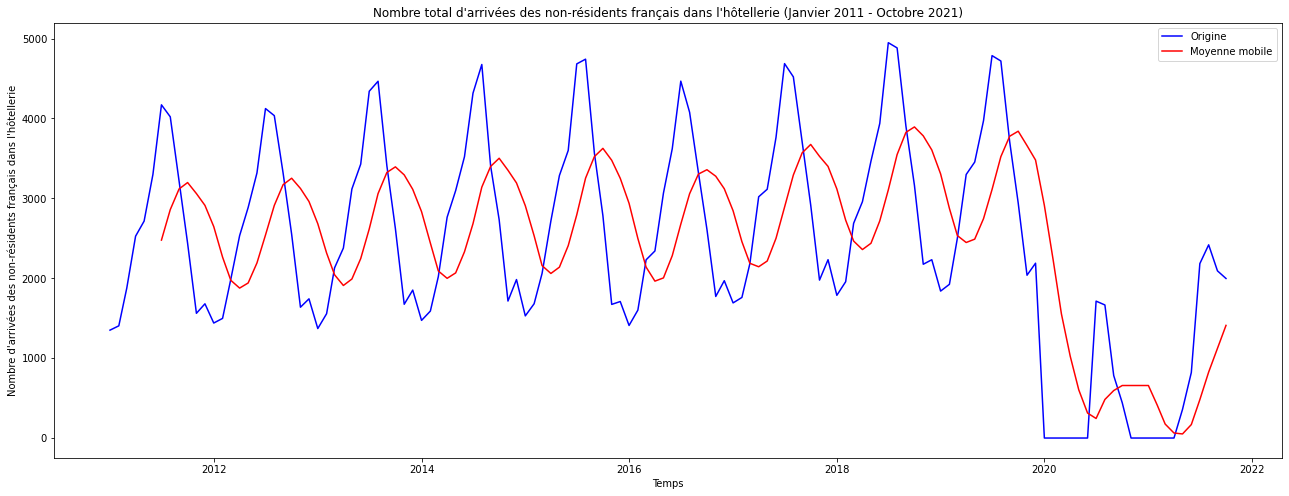

In [31]:
df_arrivees_hotel_non_residents_temps = df_arrivees_hotel_non_residents.groupby('date').sum()
df_arrivees_hotel_non_residents_temps.reset_index(inplace=True)
df_arrivees_hotel_non_residents_value = df_arrivees_hotel_non_residents_temps['value_in_thousands']

x = df_arrivees_hotel_non_residents_temps["date"]
y = df_arrivees_hotel_non_residents_temps["value_in_thousands"]
z = rolling_mean = df_arrivees_hotel_non_residents_value.rolling(window = 7).mean()

fig = plt.figure(1, figsize=(22, 8))

plt.plot(x, y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title("Nombre total d'arrivées des non-résidents français dans l'hôtellerie (Janvier 2011 - Octobre 2021)")
plt.legend(loc = 'best')
plt.xlabel('Temps')
plt.ylabel("Nombre d'arrivées des non-résidents français dans l'hôtellerie")

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


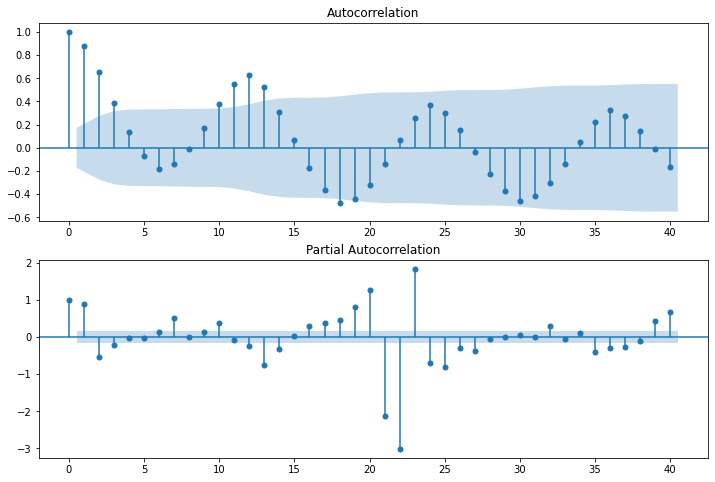

In [37]:
# autocorrélation

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_arrivees_hotel_non_residents_value, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_arrivees_hotel_non_residents_value, lags=40, ax=ax2);

D'après la fonction d'autocorrélation, on a modèle MA(14). 